In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

Read Data from MTA Website

In [2]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + '.txt')
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list, ignore_index=True)
    df.columns = df.columns.str.strip() #Exits Column name has large trailing whitespace
    return df
#get August Data YYMMDD
#Currently mta contains data from September 19, 2020 to April 04, 2020

mta = read_mta(['200919'])

"""
-----
Use the following if looking at data from June 27, 2020 to September 19, 2020
mta = read_mta(['200919', 
                '200912',
                '200905',
                '200801',
                '200808',
                '200815',
                '200822',
                '200829',
                '200725',
                '200718',
                '200711',
                '200704',
                '200627'])
-----
Use the following if looking at data from July 6, 2019 to September 28, 2019
mta = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

"""

"\n-----\nUse the following if looking at data from June 27, 2020 to September 19, 2020\nmta = read_mta(['200919', \n                '200912',\n                '200905',\n                '200801',\n                '200808',\n                '200815',\n                '200822',\n                '200829',\n                '200725',\n                '200718',\n                '200711',\n                '200704',\n                '200627'])\n-----\nUse the following if looking at data from July 6, 2019 to September 28, 2019\nmta = read_mta(['190928',\n                 '190921',\n                 '190914',\n                 '190907',\n                 '190831',\n                 '190824',\n                 '190817',\n                 '190810',\n                 '190803',\n                 '190727',\n                 '190720',\n                 '190713',\n                 '190706'\n                 ])\n\n"

In [3]:
mta.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009


In [4]:
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209661 entries, 0 to 209660
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   C/A       209661 non-null  object
 1   UNIT      209661 non-null  object
 2   SCP       209661 non-null  object
 3   STATION   209661 non-null  object
 4   LINENAME  209661 non-null  object
 5   DIVISION  209661 non-null  object
 6   DATE      209661 non-null  object
 7   TIME      209661 non-null  object
 8   DESC      209661 non-null  object
 9   ENTRIES   209661 non-null  int64 
 10  EXITS     209661 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.6+ MB


In [5]:
mta.describe()

,ENTRIES,EXITS
count,2.096610e+05,2.096610e+05
mean,4.237896e+07,3.499690e+07
std,2.166274e+08,1.982265e+08
min,0.000000e+00,0.000000e+00
25%,2.646930e+05,1.111290e+05
50%,1.730230e+06,1.012140e+06
75%,6.349613e+06,4.246031e+06
max,2.128746e+09,2.123199e+09


Early things to take note of: 
* 209661 rows of data
* Large range in turnstile Entries and Exit Tickers (suggests turnstiles may have started at different times)

## Clean Data
* convert to datetime and sort in ascending order
* get change in turnstile data
* remove negative entries and exits
* remove total traffic greater than 2400
* convert datetime to day of week int


In [6]:
#convert to datetime and sort
mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)
mta.sort_values(by=['datetime'], inplace=True)

In [7]:
#recovered audits are <1% of total data. Drop!
mta.DESC.value_counts()

REGULAR       209111
RECOVR AUD       550
Name: DESC, dtype: int64

In [8]:
#only interested in regular audits. 
mta = pd.DataFrame(mta[mta.DESC == 'REGULAR'])

In [9]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta['n_in'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_out'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [10]:
#adding n_in and n_out to get total turnstile traffic between audits
mta['turn_traffic'] = mta.n_in + mta.n_out

In [11]:
#n_in and n_out have negative quantities
mta.describe()

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,2.091110e+05,2.091110e+05,2.041570e+05,2.041570e+05,2.041570e+05
mean,4.234850e+07,3.499265e+07,5.247209e+03,2.132242e+03,7.379452e+03
std,2.165280e+08,1.982371e+08,2.501973e+06,1.077691e+06,3.579313e+06
min,0.000000e+00,0.000000e+00,-1.200344e+07,-1.663366e+07,-2.863710e+07
25%,2.644255e+05,1.112645e+05,1.000000e+00,2.000000e+00,5.000000e+00
50%,1.723604e+06,1.011338e+06,1.700000e+01,1.800000e+01,4.700000e+01
75%,6.349051e+06,4.245339e+06,6.600000e+01,6.100000e+01,1.400000e+02
max,2.128746e+09,2.123199e+09,1.130282e+09,4.864105e+08,1.616692e+09


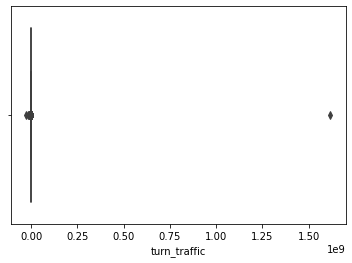

In [12]:
sns.boxplot(mta.turn_traffic)

In [13]:
len(mta[mta.turn_traffic<0])/len(mta)

0.0077853388870025965

Takeaways:
* Large gap in maximum turnstile traffic data ~1 BILLION
* Some Negative Values but they take up less than 1% of the data

Lets drop the negative values and assume that at a maximum, ten people will pass through a turnstile in a minute.  
This caps the four hour traffic at 2400 people passing through a specific turnstile. 

In [14]:
mask = (mta.n_in >= 0) & (mta.n_out >= 0) & (mta.turn_traffic >= 0) & (mta.turn_traffic < 2400)
mta = mta[mask]

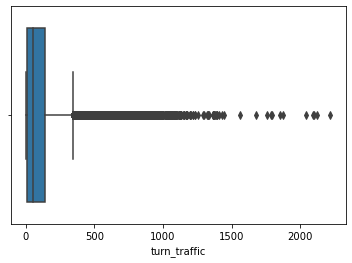

In [15]:
sns.boxplot(mta.turn_traffic)

For later use, break down the further mta data to show their individual weekdays.

In [16]:
mta['day_of_week'] = mta['datetime'].apply(lambda x : x.weekday())


## Analysis
<a href='#Ranking Stations Traffic For entire DataFrame'>Ranking Stations Traffic For Entire DataFrame</a>  
<a href='#Verifying Data From 2019'>Verifying Data From 2019</a>


<a id='Ranking Stations Traffic For entire DataFrame'></a>
### Ranking Stations Traffic For entire DataFrame

In [17]:
stations_totals = mta.groupby('STATION', as_index=False).turn_traffic.sum()

In [18]:
stations_totals.rename(columns={'turn_traffic':'total_st_traffic'}, inplace=True)

In [19]:
stations_totals.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [20]:
stations_totals[:11]

,STATION,total_st_traffic
61,34 ST-PENN STA,448535.0
59,34 ST-HERALD SQ,355745.0
110,86 ST,350144.0
9,125 ST,336779.0
14,14 ST-UNION SQ,320217.0
233,GRD CNTRL-42 ST,302224.0
46,23 ST,274861.0
68,42 ST-PORT AUTH,274861.0
217,FLUSHING-MAIN,268476.0
226,FULTON ST,260552.0


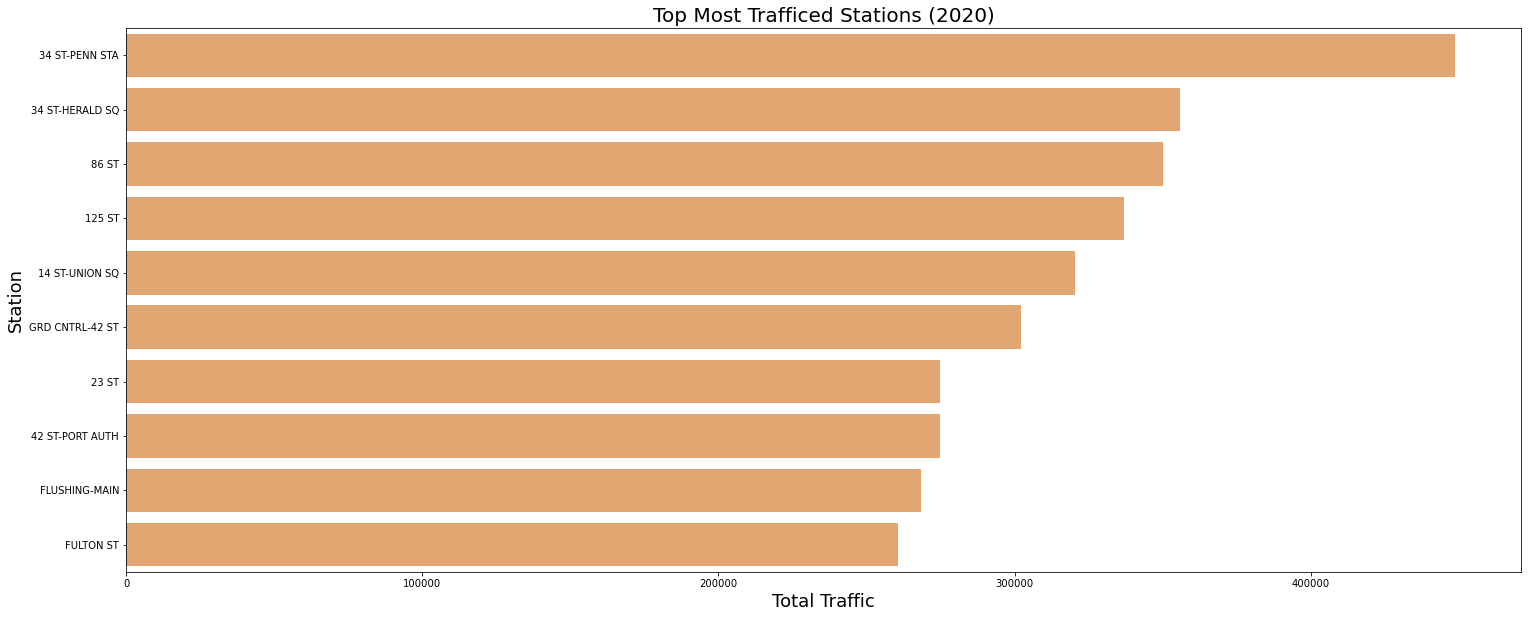

In [21]:
plt.figure(figsize=[25,10])

sns.barplot(x='total_st_traffic', y='STATION', data=stations_totals[:10], color='sandybrown')
plt.title('Top Most Trafficed Stations (2020)', fontsize=20)
plt.xlabel('Total Traffic', fontsize=18)
plt.ylabel('Station', fontsize=18);

<a id='Verifying Data From 2019'></a>
### Verifying Data From 2019

In [22]:
#loading in 2019 data
mta19 = read_mta(['190928',
                 '190921',
                 '190914',
                 '190907',
                 '190831',
                 '190824',
                 '190817',
                 '190810',
                 '190803',
                 '190727',
                 '190720',
                 '190713',
                 '190706'
                 ])

In [23]:
mta19.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,00:00:00,REGULAR,7206966,2441290
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,04:00:00,REGULAR,7206983,2441292
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,08:00:00,REGULAR,7207003,2441323
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,12:00:00,REGULAR,7207073,2441395
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,16:00:00,REGULAR,7207260,2441450
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,20:00:00,REGULAR,7207572,2441489
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,00:00:00,REGULAR,7207748,2441513
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,04:00:00,REGULAR,7207773,2441521
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,08:00:00,REGULAR,7207784,2441536
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/22/2019,12:00:00,REGULAR,7207848,2441602


#### Cleaning

In [24]:
mta19['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)

In [25]:
mta19 = pd.DataFrame(mta19[mta19.DESC == 'REGULAR'])

In [26]:
mta19.sort_values(by=['datetime'], inplace=True)

In [27]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta19['n_in'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta19['n_out'] = mta19.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [28]:
mta19.describe()

,ENTRIES,EXITS,n_in,n_out
count,2.675155e+06,2.675155e+06,2.670206e+06,2.670206e+06
mean,4.228635e+07,3.480474e+07,1.132906e+03,-3.170237e+02
std,2.158342e+08,1.990198e+08,6.567801e+06,4.933411e+06
min,0.000000e+00,0.000000e+00,-2.037959e+09,-1.971944e+09
25%,2.863705e+05,1.203080e+05,6.000000e+00,6.000000e+00
50%,2.077570e+06,1.186331e+06,6.400000e+01,4.700000e+01
75%,6.662910e+06,4.578948e+06,2.190000e+02,1.570000e+02
max,2.129224e+09,2.123963e+09,2.129142e+09,1.971923e+09


In [29]:
#adding n_in and n_out to get total turnstile traffic between audits
mta19['turn_traffic'] = mta19.n_in + mta19.n_out

In [30]:
mask19 = (mta19.n_in >= 0) & (mta19.n_out >= 0) & (mta19.turn_traffic >= 0) & (mta19.turn_traffic < 2400)
mta19 = mta19[mask19]

In [31]:
mta19['total_st_traffic'] = mta19.groupby('STATION').turn_traffic.transform('sum')

In [32]:
mta19.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,total_st_traffic
1457954,B026,R230,00-00-03,NECK RD,BQ,BMT,08/05/2019,16:00:00,REGULAR,2059765,290934,NaT,151.0,36.0,187.0,458106.0
405875,R637,R451,00-00-01,WINTHROP ST,25,IRT,09/16/2019,21:00:00,REGULAR,1808776,179480,NaT,453.0,45.0,498.0,414317.0
2508781,H001,R175,00-00-02,8 AV,ACEL,BMT,07/01/2019,05:00:00,REGULAR,15780343,8973995,NaT,107.0,22.0,129.0,4926417.0
1442433,A016,R081,03-00-00,49 ST,NQRW,BMT,08/07/2019,20:00:00,REGULAR,3837548,4628870,NaT,723.0,209.0,932.0,2895209.0
466603,N078,R175,01-00-00,14 ST,ACEL,IND,09/07/2019,17:00:00,REGULAR,217550,308444,NaT,491.0,785.0,1276.0,7925907.0


In [33]:
mta19.STATION.value_counts()

34 ST-PENN STA     54278
FULTON ST          51754
23 ST              37980
GRD CNTRL-42 ST    34935
86 ST              33003
                   ...  
225 ST              1080
182-183 STS         1069
190 ST              1065
CLEVELAND ST        1060
SUTTER AV           1058
Name: STATION, Length: 378, dtype: int64

#### Analysis

In [34]:
stations_totals19 = mta19[['STATION', 'total_st_traffic']]

In [35]:
stations_totals19 = stations_totals19.drop_duplicates()

In [36]:
stations_totals19.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [37]:
top_ten_stations_totals19 = stations_totals19[:11]
top_ten_stations_totals19

,STATION,total_st_traffic
53269,34 ST-PENN STA,22895035.0
159311,GRD CNTRL-42 ST,18070068.0
55956,23 ST,14427153.0
4886,14 ST-UNION SQ,14352618.0
208777,34 ST-HERALD SQ,14310239.0
208235,TIMES SQ-42 ST,14132403.0
151628,FULTON ST,13448705.0
52345,42 ST-PORT AUTH,12120128.0
164666,86 ST,11467283.0
46833,125 ST,10840362.0


### Compare to 2020 data

In [38]:
top_ten_stations_totals20 = stations_totals[:11]
top_ten_stations_totals20

,STATION,total_st_traffic
61,34 ST-PENN STA,448535.0
59,34 ST-HERALD SQ,355745.0
110,86 ST,350144.0
9,125 ST,336779.0
14,14 ST-UNION SQ,320217.0
233,GRD CNTRL-42 ST,302224.0
46,23 ST,274861.0
68,42 ST-PORT AUTH,274861.0
217,FLUSHING-MAIN,268476.0
226,FULTON ST,260552.0


### adding years to dfs

In [39]:
top_ten_stations_totals19['year'] = 2019
top_ten_stations_totals20['year'] = 2020
top_ten_stations_totals19 = top_ten_stations_totals19.reset_index()
top_ten_stations_totals20 = top_ten_stations_totals20.reset_index()

<ipython-input-39-072bd00bbf76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_stations_totals19['year'] = 2019
<ipython-input-39-072bd00bbf76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_stations_totals20['year'] = 2020


In [40]:
top_ten_stations_totals19

,index,STATION,total_st_traffic,year
0,53269,34 ST-PENN STA,22895035.0,2019
1,159311,GRD CNTRL-42 ST,18070068.0,2019
2,55956,23 ST,14427153.0,2019
3,4886,14 ST-UNION SQ,14352618.0,2019
4,208777,34 ST-HERALD SQ,14310239.0,2019
5,208235,TIMES SQ-42 ST,14132403.0,2019
6,151628,FULTON ST,13448705.0,2019
7,52345,42 ST-PORT AUTH,12120128.0,2019
8,164666,86 ST,11467283.0,2019
9,46833,125 ST,10840362.0,2019


In [41]:
#top_ten_stations_totals19.to_excel(r'/Users/zacharybrandt/Desktop/Metis/Project_1/top_ten_stations_totals19.xlsx', index = False)

In [42]:
top_ten_stations_totals20

,index,STATION,total_st_traffic,year
0,61,34 ST-PENN STA,448535.0,2020
1,59,34 ST-HERALD SQ,355745.0,2020
2,110,86 ST,350144.0,2020
3,9,125 ST,336779.0,2020
4,14,14 ST-UNION SQ,320217.0,2020
5,233,GRD CNTRL-42 ST,302224.0,2020
6,46,23 ST,274861.0,2020
7,68,42 ST-PORT AUTH,274861.0,2020
8,217,FLUSHING-MAIN,268476.0,2020
9,226,FULTON ST,260552.0,2020


In [43]:
#This cell was used to export the data as excel
#top_ten_stations_totals20.to_excel(r'/Users/zacharybrandt/Desktop/Metis/Project_1/top_ten_stations_totals20.xlsx', index = False)

### Combining into one df

In [44]:
top_ten_stations_both = pd.concat([top_ten_stations_totals19, top_ten_stations_totals20], ignore_index = True)
top_ten_stations_both

,index,STATION,total_st_traffic,year
0,53269,34 ST-PENN STA,22895035.0,2019
1,159311,GRD CNTRL-42 ST,18070068.0,2019
2,55956,23 ST,14427153.0,2019
3,4886,14 ST-UNION SQ,14352618.0,2019
4,208777,34 ST-HERALD SQ,14310239.0,2019
5,208235,TIMES SQ-42 ST,14132403.0,2019
6,151628,FULTON ST,13448705.0,2019
7,52345,42 ST-PORT AUTH,12120128.0,2019
8,164666,86 ST,11467283.0,2019
9,46833,125 ST,10840362.0,2019


### Ploting the two

<Figure size 1440x720 with 0 Axes>

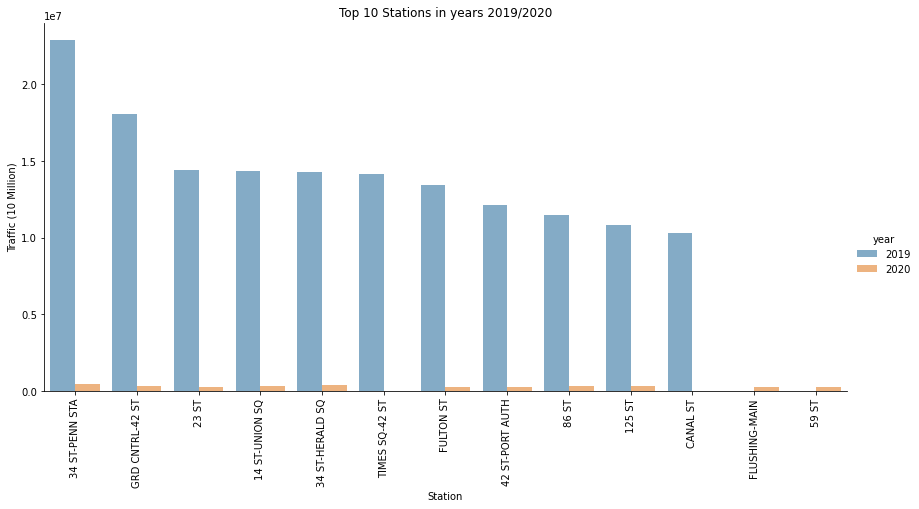

In [45]:
plt.figure(figsize=[20,10])
compare_years = sns.catplot(
    data = top_ten_stations_both, kind = "bar",
    x = "STATION", y ="total_st_traffic", hue = "year", 
    palette = sns.color_palette(), alpha=.6, height=6,
    aspect = 2
)
compare_years.set_xticklabels(rotation=90)
compare_years.set(xlabel="Station", ylabel = "Traffic (10 Million)")
compare_years.set(title = "Top 10 Stations in years 2019/2020")

In [46]:
compare_years.savefig("compare_years.png")

---

**Filter for Top N Stations (N=25)**

In [47]:
n=25

In [48]:
#Assume focus on top ten total traffic

#increase to top 25
s = [each for _, each in stations_totals[:n]['STATION'].items()]

In [49]:
#Change df name to top_ranking
top_ranked_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [50]:
top_ranked_df.STATION.value_counts()

34 ST-PENN STA     3995
FULTON ST          3931
GRD CNTRL-42 ST    3130
23 ST              2937
86 ST              2621
CANAL ST           2342
59 ST              2251
34 ST-HERALD SQ    2187
ATL AV-BARCLAY     2090
14 ST              1992
42 ST-PORT AUTH    1965
PATH NEW WTC       1744
TIMES SQ-42 ST     1722
125 ST             1685
59 ST COLUMBUS     1681
14 ST-UNION SQ     1681
47-50 STS ROCK     1476
96 ST              1473
CHURCH AV          1442
KINGS HWY          1225
72 ST              1153
FLUSHING-MAIN       980
JKSN HT-ROOSVLT     902
JAMAICA CENTER      824
145 ST              820
Name: STATION, dtype: int64

In [52]:
#try top_ranked_df.dt.dayofweek()
#top_ranked_df['day_of_week'] = top_ranked_df['datetime'].apply(lambda x : x.weekday())

**Determine Daily Cumulative traffic by day of week from Top n Stations of all time**

In [143]:
daily_df = mta[mta.STATION.isin(s[:n])].groupby(['STATION','day_of_week'], as_index=False).turn_traffic.sum()
daily_df.rename(columns={'turn_traffic':'daily_traffic'}, inplace=True)

Text(0.5, 1.0, 'Cumulative Daily Traffic')

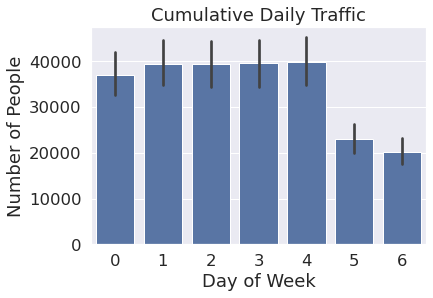

In [144]:
sns.barplot(x='day_of_week', y='daily_traffic', data=daily_df, color='b')

plt.xlabel('Day of Week')
plt.ylabel('Number of People')
plt.title('Cumulative Daily Traffic')

In [57]:
top_ranked_df['traffic_by_time_by_station'] = top_ranked_df.groupby(['STATION', 'day_of_week', 'TIME']).turn_traffic.transform('sum')

In [58]:
top_ranked_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,daily_traffic,traffic_by_time_by_station
58128,N076,R111,00-00-02,23 ST,CE,IND,09/12/2020,04:00:00,REGULAR,375812,234710,2020-09-12 04:00:00,13.0,10.0,23.0,5,24106.0,316.0
3458,A022,R022,01-06-00,34 ST-HERALD SQ,BDFMNQRW,BMT,09/12/2020,04:00:00,REGULAR,67828565,18909317,2020-09-12 04:00:00,3.0,3.0,6.0,5,33981.0,646.0
3374,A022,R022,01-00-01,34 ST-HERALD SQ,BDFMNQRW,BMT,09/12/2020,04:00:00,REGULAR,28218607,11740429,2020-09-12 04:00:00,9.0,5.0,14.0,5,33981.0,646.0
57919,N075,R111,01-05-01,23 ST,CE,IND,09/12/2020,04:00:00,REGULAR,6,1209,2020-09-12 04:00:00,0.0,0.0,0.0,5,24106.0,316.0
15279,B016,R098,00-03-01,CHURCH AV,BQ,BMT,09/12/2020,04:00:00,REGULAR,2040832,1058563,2020-09-12 04:00:00,6.0,23.0,29.0,5,14799.0,604.0


In [59]:
top_ranked_df['d_traffic'] = top_ranked_df.groupby(['STATION', 'DATE']).turn_traffic.transform('sum')
top_ranked_df['mean_d_traffic'] = top_ranked_df.groupby(['STATION','day_of_week']).d_traffic.transform('mean')

### Ranking Stations filtered for Weekdays

In [177]:
wkday_df = pd.DataFrame(mta[mta.day_of_week < 5])

In [185]:
wkday_rank = wkday_df.groupby(['STATION'], as_index=False).turn_traffic.sum()
wkday_rank.sort_values('turn_traffic', ascending=False, inplace=True)
wkday_rank.head(7)

,STATION,turn_traffic
61,34 ST-PENN STA,368282.0
59,34 ST-HERALD SQ,292459.0
110,86 ST,284948.0
9,125 ST,269774.0
233,GRD CNTRL-42 ST,258360.0
14,14 ST-UNION SQ,251918.0
46,23 ST,230760.0


Text(0.5, 0, 'Cumulative Number of People')

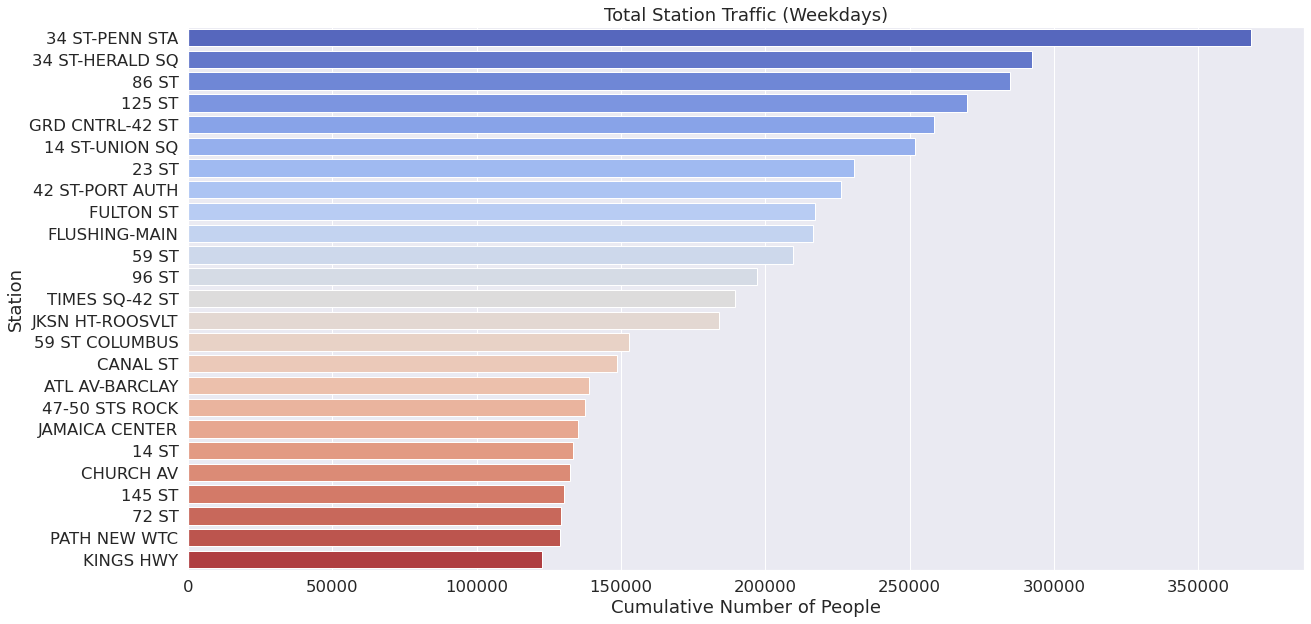

In [180]:
plt.figure(figsize=(20,10))

sns.barplot(x='turn_traffic', y='STATION', data=wkday_rank[:25], palette='coolwarm')
plt.title('Total Station Traffic (Weekdays)')
plt.ylabel('Station')
plt.xlabel('Cumulative Number of People');

**filter for top N stations (n)**

In [70]:
#did not use this code?
wkday_df['daily_traffic'] = wkday_df.groupby(['STATION','DATE']).turn_traffic.transform('sum')

### Top Stations Average Traffic by Day 

In [202]:
df = mta[mta.STATION.isin(s)].groupby(['STATION', 'DATE', 'day_of_week'], as_index=False).turn_traffic.sum()
df['mean_d_traffic'] = df.groupby(['STATION','day_of_week']).turn_traffic.transform('mean')
df.drop(columns=['turn_traffic','DATE'], inplace=True)
df.drop_duplicates(inplace=True)
df.head()
#turn_traffic and mean_d_traffic will be equal if you only test with one week!

,STATION,day_of_week,mean_d_traffic
0,125 ST,5,35307.0
1,125 ST,6,31698.0
2,125 ST,0,51064.0
3,125 ST,1,54180.0
4,125 ST,2,53936.0


In [203]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
df.day_of_week = df.day_of_week.map(lambda x : str(x)).map(wkday_dict)
#df = df[(df.day_of_week!='Sat') & (df.day_of_week!='Sun')]

In [76]:
#Filter for Lower Manhatan Stations Only
s3 = s[0:2]+s[4:9]

Text(0.5, 1.0, 'Average Daily Traffic')

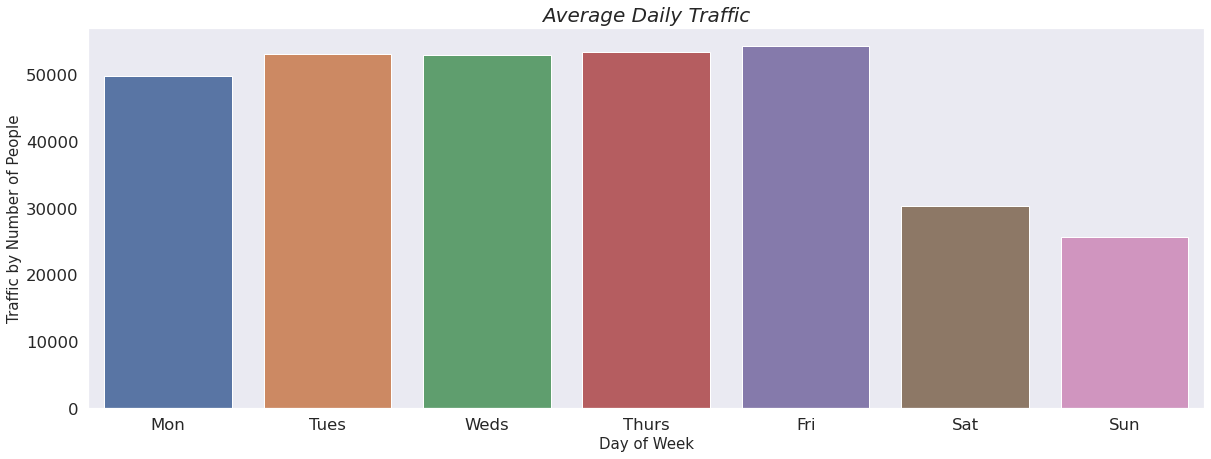

In [204]:

plt.figure(figsize=[20,7])
LIMIT = 9
sns.set_style('dark')
sns.barplot(x='day_of_week', 
            y='mean_d_traffic',  
            data=df[(df.STATION.isin(s3))], 
            order=['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],
            ci=None)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Traffic by Number of People', fontsize=15)
plt.title('Average Daily Traffic', fontsize=20, fontstyle='oblique')
#use s3 in hue order b/c its the top 5 in order

In [207]:
pivot_df = df[df.STATION.isin(s3)].pivot(index='day_of_week', columns='STATION', values='mean_d_traffic')
pivot_df

STATION,14 ST-UNION SQ,23 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-PORT AUTH,FULTON ST,GRD CNTRL-42 ST
day_of_week,,,,,,,
Fri,53853.0,47333.0,60826.0,75607.0,47020.0,44240.0,51265.0
Mon,46776.0,41943.0,55596.0,70590.0,43335.0,41087.0,49319.0
Sat,38576.0,24106.0,33981.0,42591.0,25664.0,23672.0,23587.0
Sun,29723.0,19995.0,29305.0,37662.0,22834.0,19622.0,20277.0
Thurs,49846.0,47837.0,58795.0,74653.0,45336.0,43877.0,53828.0
Tues,49618.0,46560.0,59235.0,74098.0,45368.0,44433.0,52136.0
Weds,51825.0,47087.0,58007.0,73334.0,45304.0,43621.0,51812.0


Text(0.5, 1.0, 'Daily Traffic of Top Ten Busiest Stations')

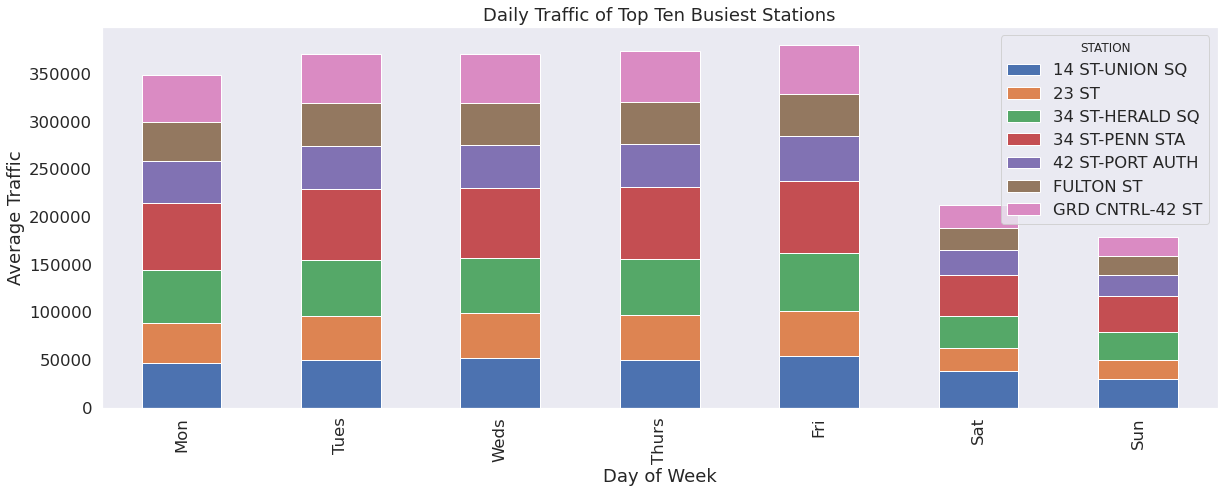

In [208]:
pivot_df.loc[['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'],:].plot.bar(stacked=True, figsize=(20,7))

plt.xlabel('Day of Week')
plt.ylabel('Average Traffic')
plt.title('Daily Traffic of Top Ten Busiest Stations')

In [80]:
col_order=['Mon','Tues','Weds','Thurs','Fri']
pivot_df2 = df[df.STATION.isin(s3)].pivot(index='STATION', columns='day_of_week', values='mean_d_traffic').reindex(col_order, axis=1).reindex(s3, axis=0)

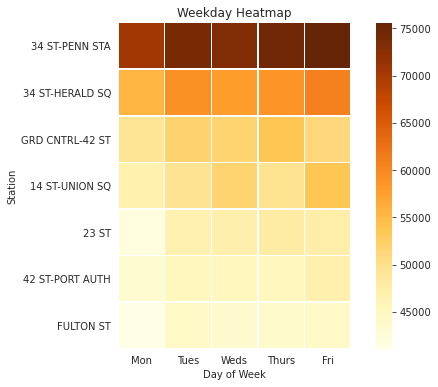

In [81]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot_df2, annot=False, linewidths=.5, ax=ax, cmap="YlOrBr", square=True)
plt.title('Weekday Heatmap')
plt.xlabel('Day of Week')
plt.ylabel('Station');

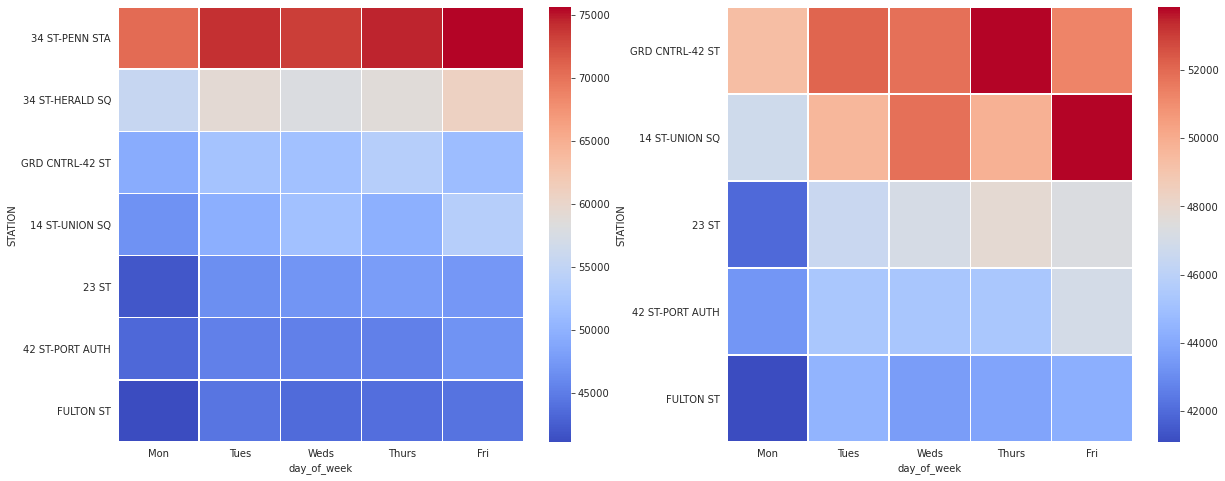

In [82]:
f, ax = plt.subplots(ncols=2, figsize=[20,8])
kwargs = {'square':False, 'linewidths':'0.5', 'annot':False, 'cmap':'coolwarm'}
sns.heatmap(pivot_df2, ax=ax[0], **kwargs)
sns.heatmap(pivot_df2.drop(labels=['34 ST-PENN STA', '34 ST-HERALD SQ']), ax=ax[1], **kwargs);


### Chunking timeslots into windows

break time into categories
00:00:00 < dt.datetime() < 04:00:00 
EX:
* Early Morning  0-5:01
* **Morning Rush Hour 5:02-13:01** <-- 8 hour workdays
* Midafternoon 13:01-17:01
* **Evening Rush Hour 13:02-20:01**
* Late Evening 20:01-24


In [83]:
mta.TIME.value_counts().head(35)

04:00:00    17317
20:00:00    17257
08:00:00    17251
16:00:00    17227
12:00:00    17212
00:00:00    14809
17:00:00    12874
09:00:00    12863
05:00:00    12855
13:00:00    12850
21:00:00    12807
01:00:00    11032
22:00:00      779
18:00:00      777
14:00:00      776
10:00:00      775
06:00:00      775
02:00:00      666
23:00:00      273
11:00:00      272
07:00:00      272
19:00:00      272
15:00:00      271
04:22:00      245
20:22:00      245
16:22:00      245
08:22:00      245
03:00:00      234
12:22:00      210
00:22:00      210
10:30:00      140
18:30:00      140
14:30:00      140
06:30:00      140
22:30:00      140
Name: TIME, dtype: int64

In [84]:
import datetime as dt

def time_cat(x):
    curr = x.time()
    
    if dt.time(5,1) < curr < dt.time(13,1):
        return 'Morning'
    elif dt.time(13,1) < curr < dt.time(20,1):
        return 'Evening'
    else:
        return None
    

In [85]:
mta['timeblock'] = mta.datetime.apply(time_cat)

In [86]:
time_df = mta.dropna()[['STATION','DATE','turn_traffic','timeblock','day_of_week']]

In [87]:
time_df['st_daily_traff'] = time_df.groupby(['STATION','DATE','timeblock']).turn_traffic.transform('sum')

In [88]:
time_df['mean_daily_traf'] = time_df.groupby(['STATION','day_of_week','timeblock']).st_daily_traff.transform('mean')

In [89]:
time_df.drop_duplicates(inplace=True)

In [90]:
time_df.sort_values(['timeblock','st_daily_traff'], ascending=False)
time_df.drop(columns=['DATE','st_daily_traff'], inplace=True)
time_df = time_df[time_df.day_of_week<5]

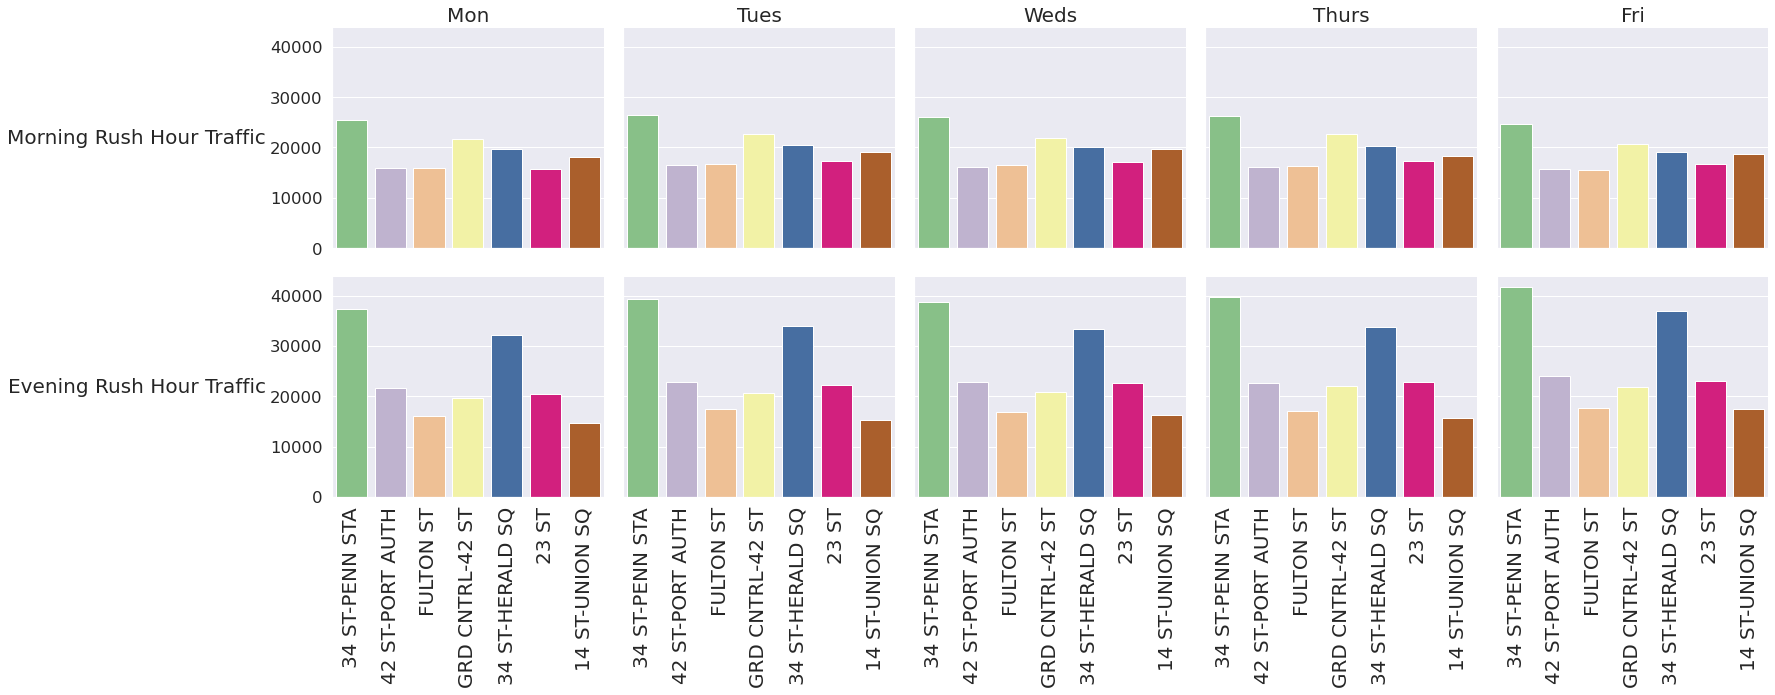

In [91]:
ntime_df = pd.DataFrame(time_df[time_df.STATION.isin(s3)])
ntime_df.drop_duplicates(inplace=True)

sns.set(font_scale=1.5)
d_compare = sns.catplot(
    x='STATION', 
    y='mean_daily_traf', 
    col='day_of_week', 
    row='timeblock', 
    data=ntime_df,
    kind='bar',
    palette='Accent')

d_compare.set_xticklabels(fontsize=20, rotation=90)
d_compare.set_axis_labels("")
d_compare.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
d_compare.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')

for i, j  in wkday_dict.items():
    try:
        d_compare.axes[0,int(i)].set_title(j, fontsize=20)
        d_compare.axes[1,int(i)].set_title('')
    except:
        pass
plt.tight_layout()

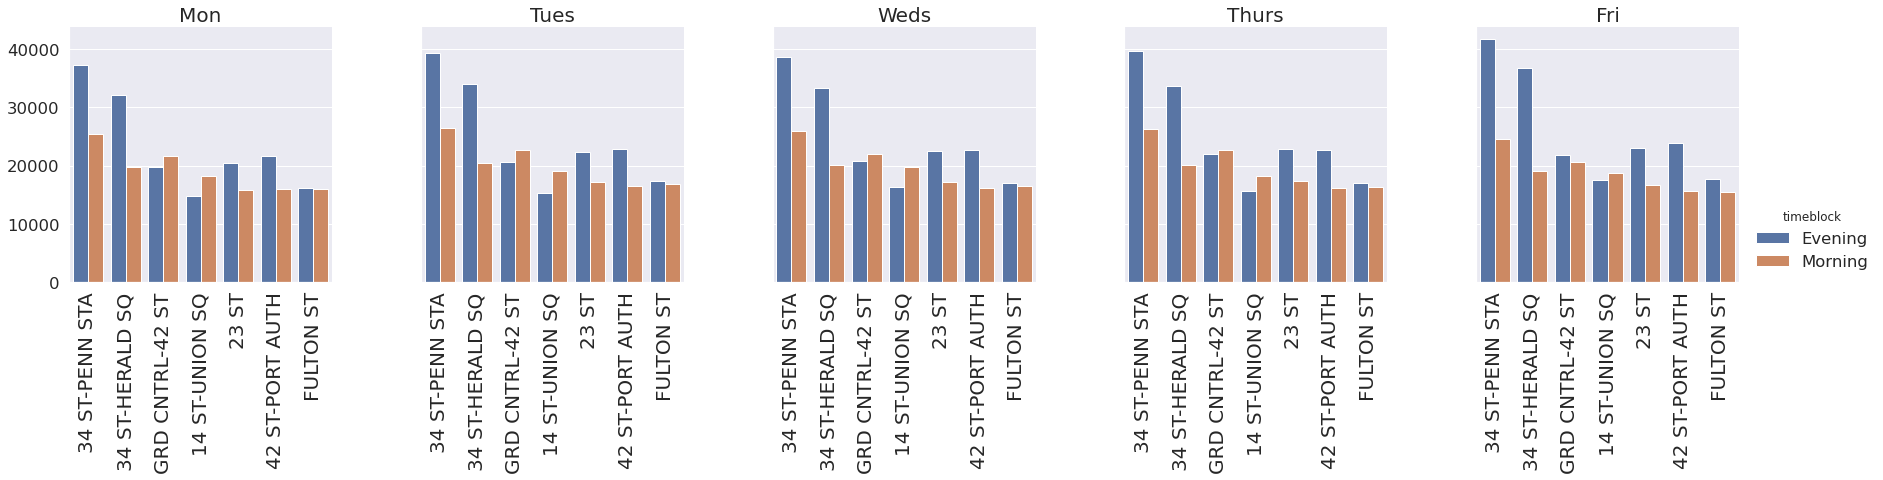

In [92]:
ntime_df = pd.DataFrame(time_df[time_df.STATION.isin(s3)])
ntime_df.drop_duplicates(inplace=True)

sns.set(font_scale=1.5)
d_compare = sns.catplot(
    x='STATION', 
    y='mean_daily_traf', 
    col='day_of_week', 
    hue='timeblock', 
    data=ntime_df,
    kind='bar',
    palette=sns.color_palette(),
    hue_order=['Evening','Morning'],
    order=s3,
    )

d_compare.set_xticklabels(fontsize=20, rotation=90)
d_compare.set_axis_labels("","")
#d_compare.axes[0,0].set_ylabel('Morning Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
#d_compare.axes[1,0].set_ylabel('Evening Rush Hour Traffic', fontsize=20, rotation=0, ha='right', va='center')
for i, j  in wkday_dict.items():
    try:
        d_compare.axes[0,int(i)].set_title(j, fontsize=20)
        d_compare.axes[1,int(i)].set_title('')
    except:
        pass


In [93]:
wkday_df['timeblock'] = wkday_df.datetime.apply(time_cat)

* horizontal(pending zach) barplot - total ridership/traffic
* horizontal barplot for top 25
* Stacked Barplot - total traffic 2019vs2020 comparrison top 10
* vertical barplot - Ridership Hotspot by Weekdays
* ~~barplot - Ridership Hotspot Rush-hour by Weekdays 

In [113]:
wkday_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,day_of_week,total_st_traffic,daily_traffic,timeblock
135020,R112A,R027,03-00-00,WALL ST,23,IRT,09/14/2020,00:00:00,REGULAR,436798,591545,2020-09-14,0.0,0.0,0.0,0,69117.0,13255.0,None
55378,N063A,R011,00-00-07,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,00:00:00,REGULAR,31003946,6788875,2020-09-14,107.0,37.0,144.0,0,226363.0,43335.0,None
103277,N512,R163,00-00-02,14 ST,FLM123,IND,09/14/2020,00:00:00,REGULAR,2835696,29249,2020-09-14,43.0,39.0,82.0,0,133506.0,24362.0,None
69853,N137,R354,00-00-00,104 ST,A,IND,09/14/2020,00:00:00,REGULAR,419214,265136,2020-09-14,13.0,2.0,15.0,0,12899.0,2394.0,None
186724,R508,R346,00-00-01,COURT SQ,7,IRT,09/14/2020,00:00:00,REGULAR,964361,751509,2020-09-14,18.0,11.0,29.0,0,43619.0,8101.0,None


In [114]:
wkday_df['hr_traff'] = wkday_df.groupby(['STATION','datetime']).turn_traffic.transform('sum')

In [115]:
t_comp = pd.DataFrame(wkday_df[['datetime','hr_traff', 'TIME']])
t_comp.drop_duplicates(inplace=True)

In [116]:
t_comp.drop_duplicates(inplace=True)

In [120]:
x = ntime_df[ntime_df.day_of_week==3].drop(columns='turn_traffic')

Text(0.5, 1.0, 'Thursday Traffic')

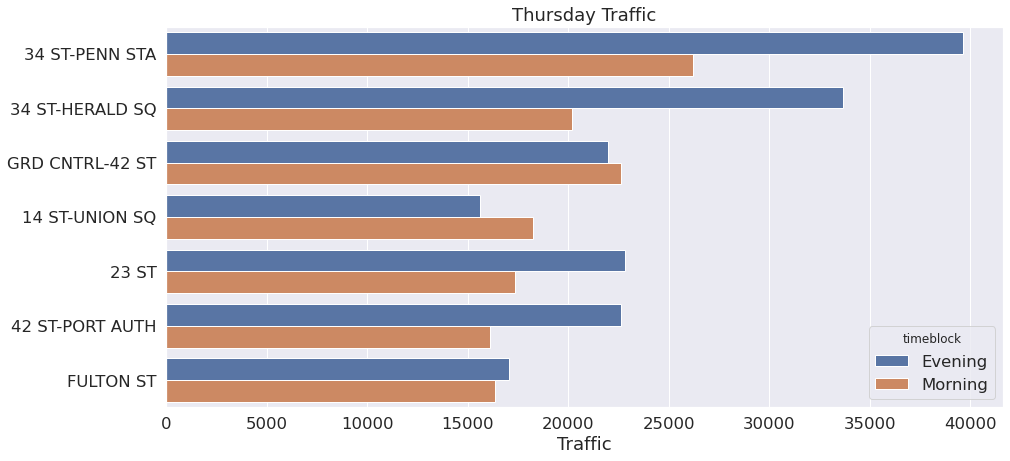

In [121]:
plt.figure(figsize=[15,7])

sns.barplot(y='STATION', x='mean_daily_traf', hue='timeblock', data=x, order=s3, hue_order=['Evening', 'Morning'])

plt.xlabel('Traffic')
plt.ylabel('')
plt.title('Thursday Traffic')


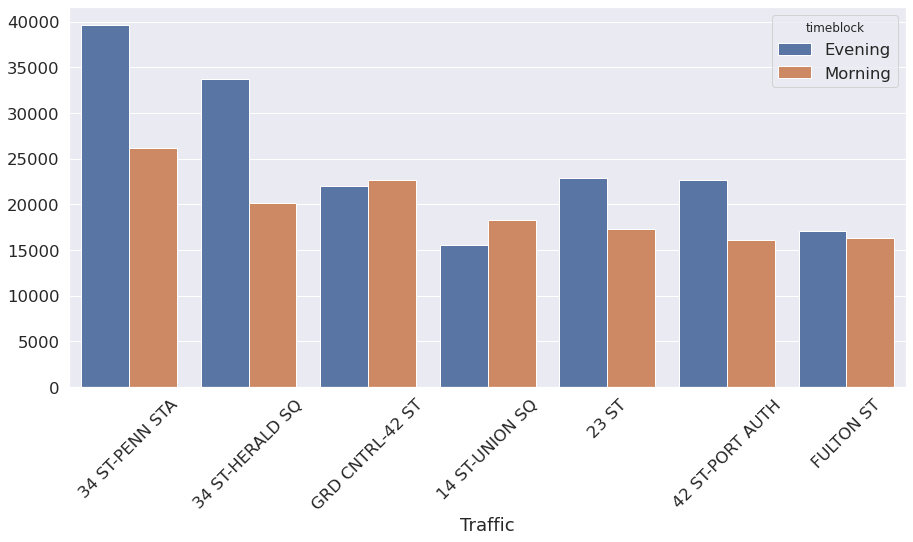

In [122]:
plt.figure(figsize=[15,7])

sns.barplot(x='STATION', y='mean_daily_traf', hue='timeblock', data=x, order=s3, hue_order=['Evening', 'Morning'])

plt.xticks(rotation=45)
plt.xlabel('Traffic')
plt.ylabel('');